# Imports

In [598]:
# Core libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Scikit-learn utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    recall_score, precision_score, f1_score,
    make_scorer, fbeta_score, cohen_kappa_score
)

# Imbalance handling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek, SMOTEENN

# XGBoost
from xgboost import XGBClassifier

# Category encoders
import category_encoders as ce

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [599]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/Final_Data/housing-classification-iter6.csv')

In [600]:
houses.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,KitchenQual,FireplaceQu,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,MiscVal,MoSold,YrSold,Id,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,BsmtFinType2,HeatingQC,Electrical,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,8450,65.0,856,3,0,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc,Gd,TA,Gd,TA,No,GLQ,Gd,NaN,60,7,5,2003,2003,196.0,706,0,150,856,854,0,1710,1,0,2,1,1,8,2003.0,548,61,0,0,0,2,2008,1,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,9600,80.0,1262,3,1,0,2,298,0,0,RL,Feedr,GasA,Pave,Y,CBlock,TA,TA,Gd,TA,Gd,ALQ,TA,TA,20,6,8,1976,1976,0.0,978,0,284,1262,0,0,1262,0,1,2,0,1,6,1976.0,460,0,0,0,0,5,2007,2,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,11250,68.0,920,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc,Gd,TA,Gd,TA,Mn,GLQ,Gd,TA,60,7,5,2001,2002,162.0,486,0,434,920,866,0,1786,1,0,2,1,1,6,2001.0,608,42,0,0,0,9,2008,3,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,9550,60.0,756,3,1,0,3,0,0,0,RL,Norm,GasA,Pave,Y,BrkTil,TA,TA,TA,Gd,No,ALQ,Gd,Gd,70,7,5,1915,1970,0.0,216,0,540,961,756,0,1717,1,0,1,0,1,7,1998.0,642,35,272,0,0,2,2006,4,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,Unf,Gd,SBrkr,Typ,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,14260,84.0,1145,4,1,0,3,192,0,0,RL,Norm,GasA,Pave,Y,PConc,Gd,TA,Gd,TA,Av,GLQ,Gd,TA,60,8,5,2000,2000,350.0,655,0,490,1145,1053,0,2198,1,0,2,1,1,9,2000.0,836,84,0,0,0,12,2008,5,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Unf,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [601]:
# Drop Id
houses.drop(columns='Id', inplace = True)

# Splitting Data

In [602]:
X = houses.drop(columns='Expensive')
y = houses['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [603]:
y_train.value_counts()

0    999
1    169
Name: Expensive, dtype: int64

# Preparing Pipeline

In [604]:
categoric_features = list(X_train.select_dtypes(include=["object"]))
numeric_features = list(X_train.select_dtypes(exclude=["object"]))

Some of the categorical features can be transformed with the ordinal encoder. So let us make a distinction about which columns that are.

In [605]:
cat_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
cat_onehot = [feature for feature in categoric_features if feature not in cat_ordinal]

In [606]:
# Define the custom orders
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_ExterQual, order_ExterCond,
        order_BsmtQual, order_BsmtCond, order_BsmtExposure, order_BsmtFinType1,
        order_BsmtFinType2, order_HeatingQC, order_KitchenQual, order_FireplaceQu,
        order_GarageQual, order_GarageCond, order_PoolQC, order_Fence
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [607]:
numeric_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent')
)

categoric_pipe_onehot = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
)

categoric_pipe_ordinal = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ordinal_enc 
)

In [608]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, numeric_features),
        ("cat_pipe_onehot", categoric_pipe_onehot, cat_onehot),
        ("cat_pipe_ordinal", categoric_pipe_ordinal, cat_ordinal),
    ]
)

In [483]:
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

In [513]:
pipeline = make_pipeline(preprocessor, xgb_clf)

In [514]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'PoolArea', 'GarageCars',
                                                   'WoodDeckSF', 'ScreenPorch',
                                                   'MSSubClass', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnr...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Evaluate Model

In [587]:
y_train_pred = pipeline.predict(X_train)

accuracy_score(y_train, y_train_pred)

1.0

In [588]:
y_test_pred = pipeline.predict(X_test)

accuracy_score(y_test, y_test_pred)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [17, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9657534246575342

In [589]:
recall_score(y_test, y_test_pred)

0.8541666666666666

# Feature Importance

In [518]:
feature_importances = pipeline.named_steps['xgbclassifier'].feature_importances_

In [519]:
# 1. Get the ColumnTransformer from the pipeline
column_transformer = pipeline.named_steps['columntransformer']

# 2. Get the feature names after one-hot encoding for categorical features
onehotencoder = preprocessor.named_transformers_['cat_pipe_onehot'].named_steps['onehotencoder']
onehot_features = list(onehotencoder.get_feature_names_out(cat_onehot))

ordinal_encoder = preprocessor.named_transformers_['cat_pipe_ordinal'].named_steps['ordinalencoder']
# Since ordinal encoding doesn't expand feature dimensions like one-hot encoding, you can just use the original features
ordinal_features = cat_ordinal

transformed_features = numeric_features + onehot_features + ordinal_features

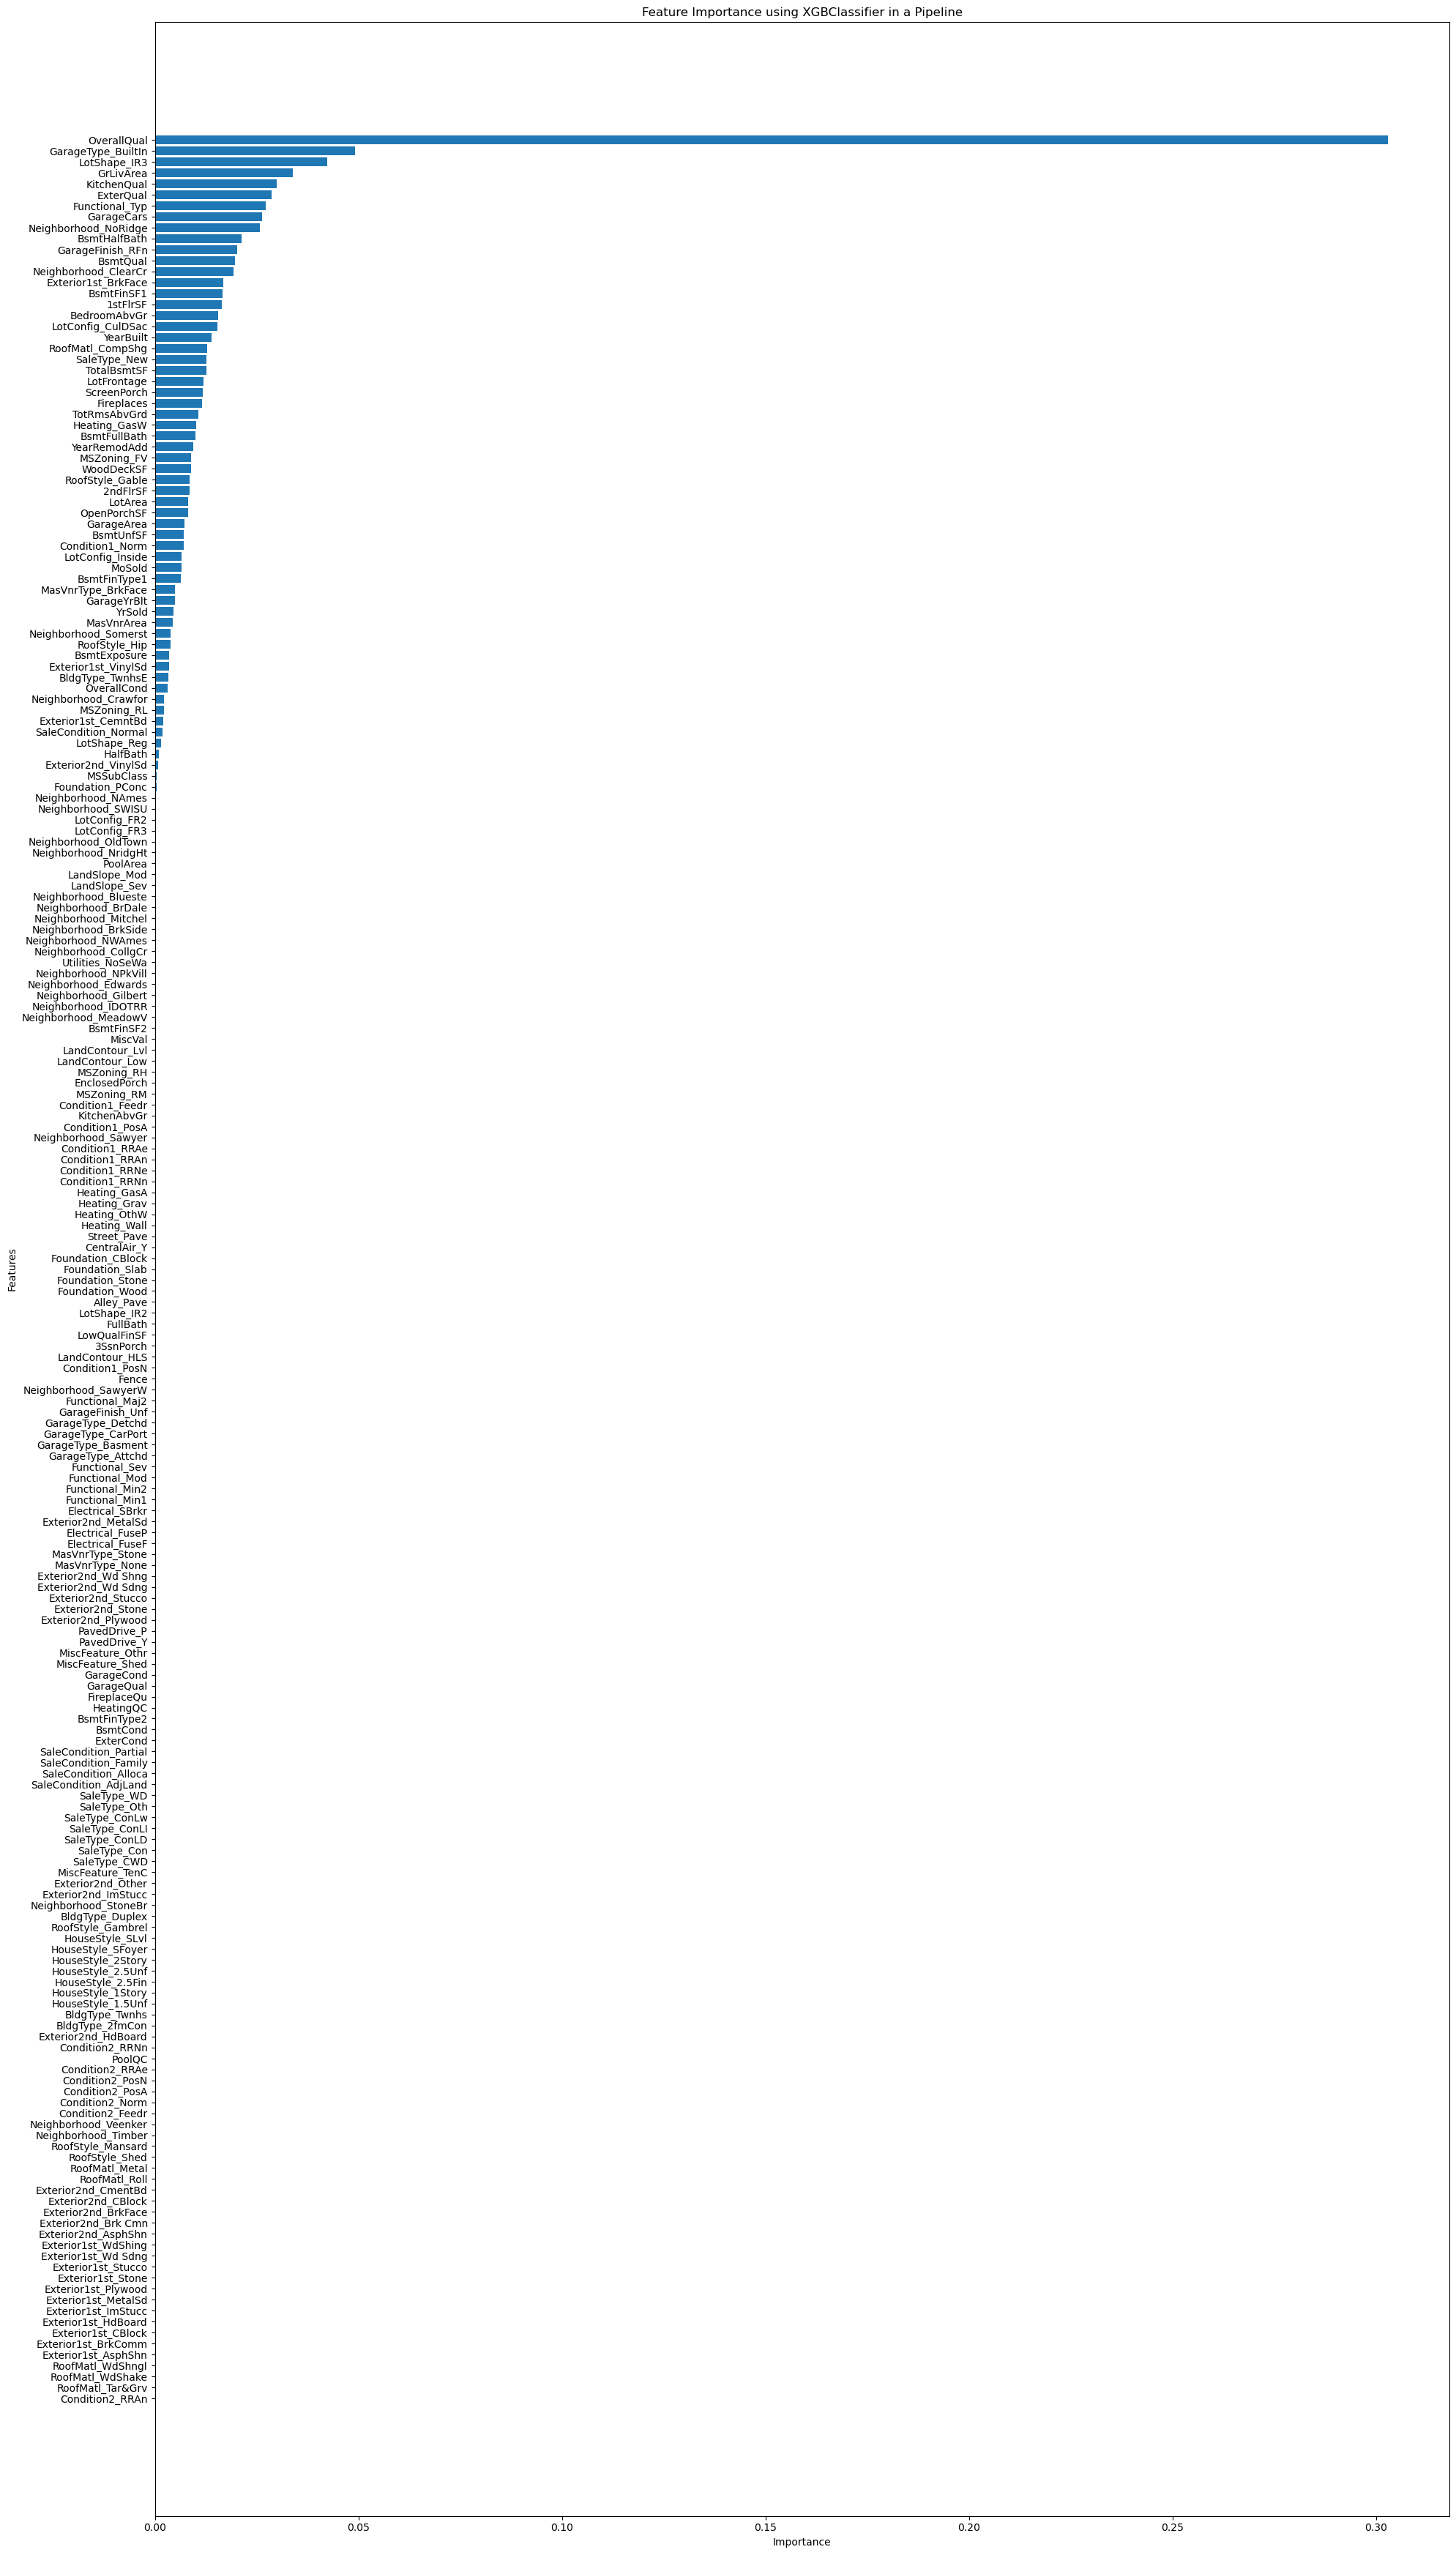

In [520]:
# Sorting the features based on importance
sorted_indices = np.argsort(feature_importances)[::-1]  # [::-1] is used to sort in descending order
sorted_features = [transformed_features[i] for i in sorted_indices]
sorted_importances = [feature_importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(20, 35))  # Adjusted the size for better visibility
plt.barh(sorted_features, sorted_importances)  # Using barh for horizontal bar plot
plt.title("Feature Importance using XGBClassifier in a Pipeline")
plt.ylabel("Features")  # Switched the label as well
plt.xlabel("Importance")
plt.yticks(rotation=0)  # No need to rotate y axis labels
plt.gca().invert_yaxis()  # To show the most important features at the top
plt.tight_layout()
plt.show()

In [521]:
# Map feature names to their importance
features_importance_dict = dict(zip(transformed_features, feature_importances))

# Display the mapped feature importance
for feature, importance in sorted(features_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

OverallQual: 0.30292513966560364
GarageType_BuiltIn: 0.04923855885863304
LotShape_IR3: 0.04242464154958725
GrLivArea: 0.03384992852807045
KitchenQual: 0.029944337904453278
ExterQual: 0.028699403628706932
Functional_Typ: 0.02716570906341076
GarageCars: 0.026267852634191513
Neighborhood_NoRidge: 0.02586270496249199
BsmtHalfBath: 0.021302372217178345
GarageFinish_RFn: 0.02030041068792343
BsmtQual: 0.019604433327913284
Neighborhood_ClearCr: 0.019271129742264748
Exterior1st_BrkFace: 0.016798051074147224
BsmtFinSF1: 0.01658276654779911
1stFlrSF: 0.01639070175588131
BedroomAbvGr: 0.015474721789360046
LotConfig_CulDSac: 0.015284131281077862
YearBuilt: 0.013940458185970783
RoofMatl_CompShg: 0.01288857776671648
SaleType_New: 0.012746895663440228
TotalBsmtSF: 0.012677911669015884
LotFrontage: 0.012024988420307636
ScreenPorch: 0.0118411248549819
Fireplaces: 0.011645639315247536
TotRmsAbvGrd: 0.01068075466901064
Heating_GasW: 0.010162401013076305
BsmtFullBath: 0.009977047331631184
YearRemodAdd: 0.0

In [522]:
features_to_drop = [feature for feature, importance in features_importance_dict.items() if importance == 0]

In [523]:
# Clean up the list to get the original Columns
def extract_name(feature):
    match = re.match(r"(.+?)_", feature)
    if match:
        return match.group(1)
    return feature

unique_names = set(map(extract_name, features_to_drop))

print(unique_names)

{'EnclosedPorch', 'MasVnrType', 'Condition1', 'BldgType', 'HeatingQC', 'LandContour', 'LotConfig', 'BsmtFullBath', 'Electrical', 'FireplaceQu', 'GarageArea', 'LotShape', 'LandSlope', 'RoofStyle', 'MasVnrArea', '3SsnPorch', 'PavedDrive', 'MSSubClass', 'Heating', 'BsmtFinType1', 'Condition2', 'CentralAir', 'Exterior1st', 'MoSold', 'BsmtFinSF2', 'MiscVal', 'Exterior2nd', 'SaleType', 'GarageType', 'GarageQual', 'HouseStyle', 'GarageCond', 'Utilities', 'PoolArea', 'Foundation', 'SaleCondition', 'ExterCond', 'FullBath', 'YrSold', 'HalfBath', 'WoodDeckSF', 'LowQualFinSF', 'MiscFeature', 'OpenPorchSF', 'MSZoning', 'LotArea', 'YearRemodAdd', 'Alley', 'KitchenAbvGr', 'BsmtUnfSF', 'GarageYrBlt', 'RoofMatl', 'Fence', '2ndFlrSF', 'BsmtCond', 'PoolQC', 'GarageFinish', 'Functional', 'BsmtFinType2', 'Street', 'Neighborhood', 'BsmtExposure', 'OverallCond'}


## other method

In [609]:
# Feature selector using XGBClassifier
selector = SelectFromModel(xgb_clf, threshold='mean')  # Here, we're selecting features whose importance is greater than the mean importance.

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('feature_selection', selector),
    ('model', XGBClassifier())
])

In [610]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'PoolArea', 'GarageCars',
                                                   'WoodDeckSF', 'ScreenPorch',
                                                   'MSSubClass', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea'...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [582]:
pipeline.named_steps['feature_selection'].get_support()

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
        True,  True, False,  True,  True,  True, False, False, False,
        True,  True,  True,  True, False, False, False,  True, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False,

In [611]:
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
print(X_train_transformed.shape)

(1168, 207)


In [612]:
def get_feature_names_after_column_transformer(column_transformer, input_features):
    # Convert input_features to a list for indexing
    input_features = list(input_features)
    
    # List to hold the output feature names
    output_features = []

    # Loop through the transformers of the ColumnTransformer
    for transformer_name, transformer, columns in column_transformer.transformers_:
        # If columns is integer indices, extract the corresponding column names
        if all(isinstance(col, int) for col in columns):
            cols_names = [input_features[idx] for idx in columns]
        else:
            cols_names = columns
            
        # For transformers that have a `get_feature_names_out` method (new in sklearn 0.24)
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_features = transformer.get_feature_names_out(cols_names)
        # For transformers without `get_feature_names_out`
        else:
            transformed_features = np.array(input_features)[columns]

        output_features.extend(transformed_features)

    return output_features

# Get the feature names after preprocessing
features_after_preprocessing = get_feature_names_after_column_transformer(pipeline.named_steps['preprocessor'], X_train.columns)

# Get the boolean mask from the feature selector
mask = pipeline.named_steps['feature_selection'].get_support()

# Apply the mask to the features after preprocessing
selected_features = np.array(features_after_preprocessing)[mask]
selected_features

array(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
       'OpenPorchSF', 'MoSold', 'MSZoning_FV', 'Condition1_Norm',
       'Heating_GasW', 'LotShape_IR3', 'LotConfig_CulDSac',
       'LotConfig_Inside', 'Neighborhood_ClearCr', 'Neighborhood_NoRidge',
       'RoofStyle_Gable', 'RoofMatl_CompShg', 'Exterior1st_BrkFace',
       'MasVnrType_BrkFace', 'Functional_Typ', 'GarageType_BuiltIn',
       'GarageFinish_RFn', 'SaleType_New', 'ExterQual', 'BsmtQual',
       'BsmtFinType1', 'KitchenQual'], dtype='<U21')

## Dropping Features and rerunning the model

In [524]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/Final_Data/housing-classification-iter6.csv')

In [525]:
# Drop Id
houses.drop(columns='Id', inplace = True)

In [526]:
# Assuming you have the set `unique_names` from the previous step
houses = houses.drop(columns=list(unique_names))

### Splitting Data

In [527]:
X = houses.drop(columns='Expensive')
y = houses['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preparing Pipeline

In [528]:
categoric_features = list(X_train.select_dtypes(include=["object"]))
numeric_features = list(X_train.select_dtypes(exclude=["object"]))

Some of the categorical features can be transformed with the ordinal encoder. So let us make a distinction about which columns that are.

In [529]:
cat_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

In [530]:
cat_ordinal = [feature for feature in cat_ordinal if feature not in unique_names]
cat_ordinal

['ExterQual', 'BsmtQual', 'KitchenQual']

In [532]:
cat_onehot = [feature for feature in categoric_features if feature not in cat_ordinal]

In [534]:
# Define the custom orders
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
#order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
#order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
#order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
#order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
#order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
#order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
#order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
#order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
#order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
#order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
#order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_ExterQual, order_BsmtQual, order_KitchenQual
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [535]:
numeric_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent')
)

categoric_pipe_onehot = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
)

categoric_pipe_ordinal = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ordinal_enc 
)

In [536]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, numeric_features),
        ("cat_pipe_onehot", categoric_pipe_onehot, cat_onehot),
        ("cat_pipe_ordinal", categoric_pipe_ordinal, cat_ordinal),
    ]
)

In [537]:
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

In [538]:
pipeline = make_pipeline(preprocessor, xgb_clf)

In [539]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['LotFrontage', 'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'GarageCars', 'ScreenPorch',
                                                   'OverallQual', 'YearBuilt',
                                                   'BsmtFinSF1', '1stFlrSF',
                                                   'GrLivArea', 'BsmtHalfBath',
                                                   'TotRmsAbvGrd']),
                                                 ('cat_pipe_oneh...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

### Evaluate Model

In [540]:
y_train_pred = pipeline.predict(X_train)

accuracy_score(y_train, y_train_pred)

1.0

In [541]:
y_test_pred = pipeline.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9554794520547946

In [542]:
recall_score(y_test, y_test_pred)

0.8125

### Grid Search

#### Randomized

In [543]:
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "xgbclassifier__learning_rate": [0.01, 0.05, 0.1],
    "xgbclassifier__n_estimators": [90, 95, 100, 105, 110],
    "xgbclassifier__max_depth": [3, 4, 5, 6, 7, 8, 9],
    "xgbclassifier__min_child_weight": [1, 5, 10]
}

In [544]:
recall_scori=make_scorer(recall_score)

In [545]:
search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=1000,
    cv=5,
    verbose=1,
    n_jobs=-2,
    random_state=42
)

In [546]:
search.fit(X_train, y_train)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 630 is smaller than n_iter=1000. Running 630 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 630 candidates, totalling 3150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['LotFrontage',
                                                                                'TotalBsmtSF',
                                                                                'BedroomAbvGr',
                                                                                'Fireplaces',
                                                                                'GarageCars',
                                                                                'ScreenPorch',
                                                                                'OverallQual',
                                                                                'YearBuilt',
                                                                                'BsmtFinSF1',
                                                                                '1stFlrSF',
                                                                                'GrLivArea',
                                                                                'BsmtHalfBath...
                                                            random_state=None, ...))]),
                   n_iter=1000, n_jobs=-2,
                   param_distributions={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                                 'median'],
                                        'xgbclassifier__learning_rate': [0.01,
                                                                         0.05,
                                                                         0.1],
                                        'xgbclassifier__max_depth': [3, 4, 5, 6,
                                                                     7, 8, 9],
                                        'xgbclassifier__min_child_weight': [1,
                                                                            5,
                                                                            10],
                                        'xgbclassifier__n_estimators': [90, 95,
                                                                        100,
                                                                        105,
                                                                        110]},
                   random_state=42, verbose=1)

In [547]:
search.best_score_

0.9555005318953815

In [548]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

0.9708904109589042

In [549]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9452054794520548

In [550]:
search.best_params_

{'xgbclassifier__n_estimators': 105,
 'xgbclassifier__min_child_weight': 5,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__learning_rate': 0.05,
 'columntransformer__num_pipe__simpleimputer__strategy': 'mean'}

In [551]:
recall_score(y_test, y_test_pred)

0.75

#### Grid Search

In [552]:
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "xgbclassifier__learning_rate": np.arange(0.01, 0.1, 0.01).tolist(),
    "xgbclassifier__n_estimators": range(90, 100),
    "xgbclassifier__max_depth": range(5,9),
    "xgbclassifier__min_child_weight": range(3,8)
}

In [553]:
recall_scori=make_scorer(recall_score)

In [554]:
search = GridSearchCV(
    pipeline,
    param_grid,
    scoring= recall_scori,
    verbose=1,
    n_jobs=-2
)

In [555]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['LotFrontage',
                                                                          'TotalBsmtSF',
                                                                          'BedroomAbvGr',
                                                                          'Fireplaces',
                                                                          'GarageCars',
                                                                          'ScreenPorch',
                                                                          'OverallQual',
                                                                          'YearBuilt',
                                                                          'BsmtFinSF1',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'BsmtHalfBath',
                                                                          'TotRmsAb...
                                                      random_state=None, ...))]),
             n_jobs=-2,
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'xgbclassifier__learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.06,
                                                          0.07, 0.08, 0.09],
                         'xgbclassifier__max_depth': range(5, 9),
                         'xgbclassifier__min_child_weight': range(3, 8),
                         'xgbclassifier__n_estimators': range(90, 100)},
             scoring=make_scorer(recall_score), verbose=1)

In [556]:
search.best_score_

0.8224598930481284

In [557]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

0.9700342465753424

In [558]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9486301369863014

In [559]:
search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'xgbclassifier__learning_rate': 0.06,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__min_child_weight': 5,
 'xgbclassifier__n_estimators': 90}

In [560]:
recall_score(y_test, y_test_pred)

0.7708333333333334

# Classification performance metrics

## Confusion Matrix

In [561]:
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

In [613]:
cm = confusion_matrix(y_test, y_test_pred)

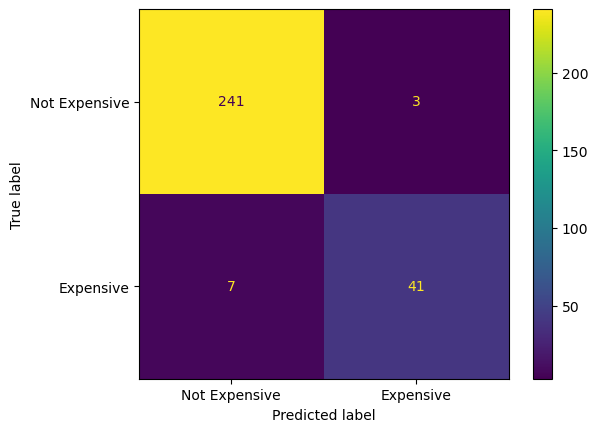

In [614]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Expensive', 'Expensive'])
disp.plot()

plt.show()

## Cohen’s Kappa Coefficient

In [592]:
kappa_score = cohen_kappa_score(y_test, y_test_pred)
print(kappa_score)

0.8710247349823321


In [593]:
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8913


In [594]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

Specificity: 0.9877


In [595]:
precision = precision_score(y_test, y_test_pred)
precision

0.9318181818181818

In [596]:
recall_score(y_test, y_test_pred)

0.8541666666666666

# Oversampling

In [411]:
resampling = [
    (RandomOverSampler(random_state=42), False), # No scaling needed
    (SMOTE(random_state=42), True), # Scaling needed
    (ADASYN(random_state=42), True), # Scaling needed
    (RandomUnderSampler(random_state=42), False), # No scaling needed
    (TomekLinks(), False), # No scaling needed
    (NeighbourhoodCleaningRule(), False), # No scaling needed
    (SMOTETomek(random_state=42), True), # Scaling needed
    (SMOTEENN(random_state=42), True)  # Scaling needed
]

RandomOverSampler(random_state=42) - accuracy score train: 1.0
RandomOverSampler(random_state=42) - accuracy score test: 0.9623287671232876


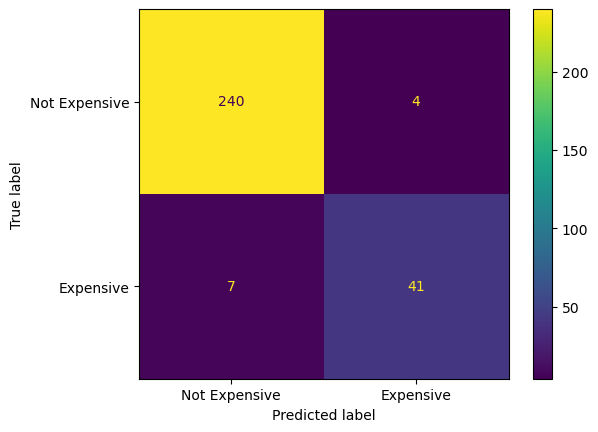

SMOTE(random_state=42) - accuracy score train: 1.0
SMOTE(random_state=42) - accuracy score test: 0.958904109589041


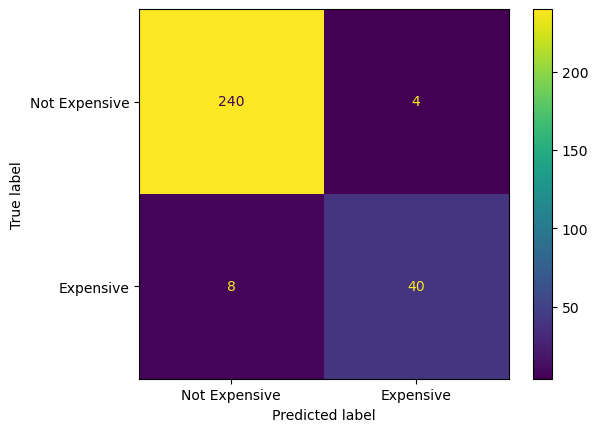

ADASYN(random_state=42) - accuracy score train: 1.0
ADASYN(random_state=42) - accuracy score test: 0.9623287671232876


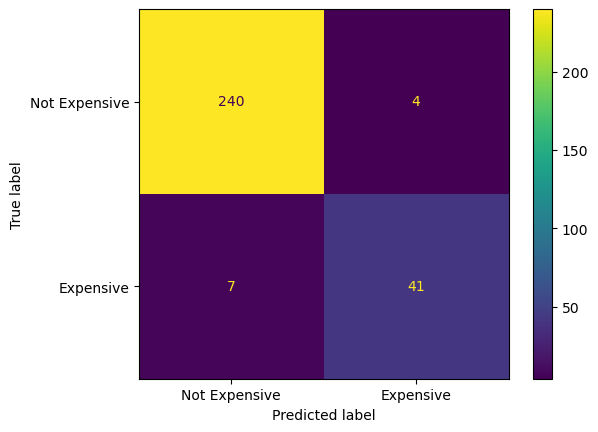

RandomUnderSampler(random_state=42) - accuracy score train: 0.9409246575342466
RandomUnderSampler(random_state=42) - accuracy score test: 0.9486301369863014


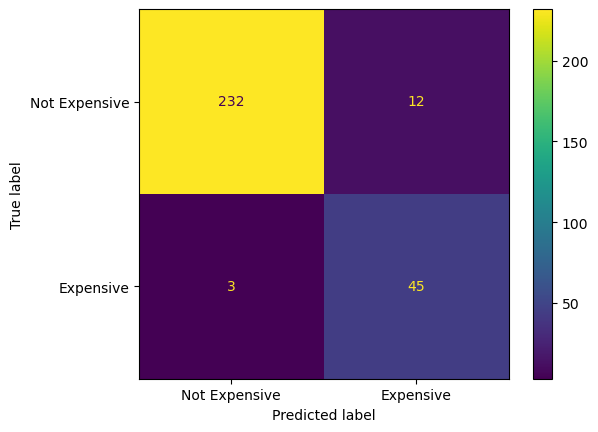

TomekLinks() - accuracy score train: 0.9940068493150684
TomekLinks() - accuracy score test: 0.9623287671232876


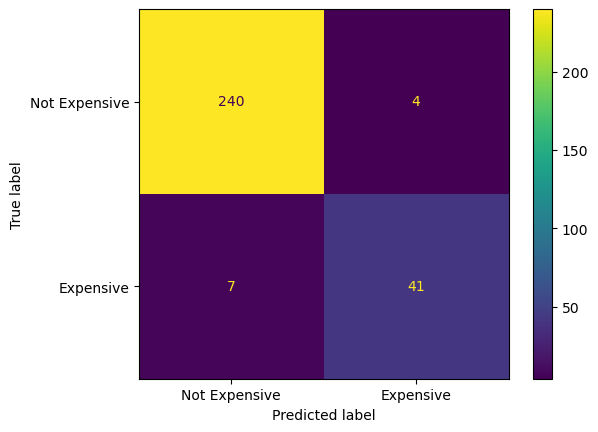

NeighbourhoodCleaningRule() - accuracy score train: 0.9631849315068494
NeighbourhoodCleaningRule() - accuracy score test: 0.9486301369863014


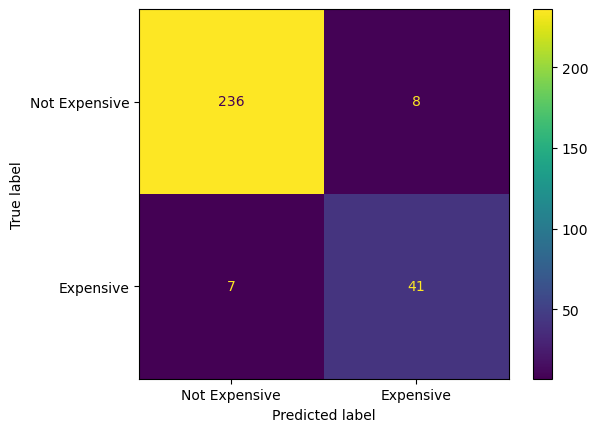

SMOTETomek(random_state=42) - accuracy score train: 1.0
SMOTETomek(random_state=42) - accuracy score test: 0.958904109589041


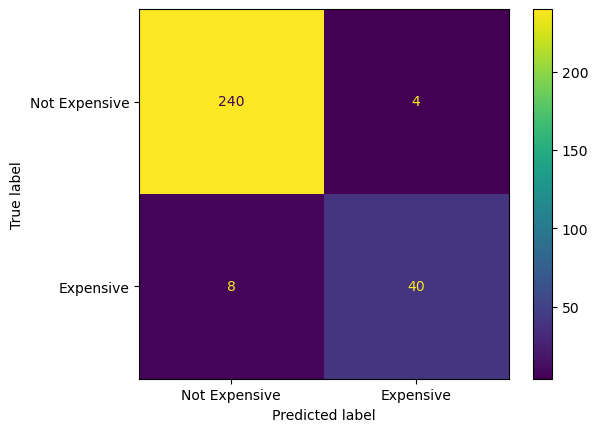

SMOTEENN(random_state=42) - accuracy score train: 0.958904109589041
SMOTEENN(random_state=42) - accuracy score test: 0.952054794520548


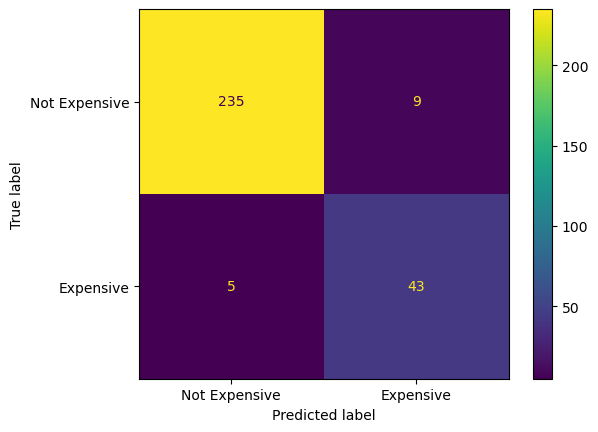

In [412]:
results = pd.DataFrame(columns=['algorithm', 'accuracy', 'recall_score', 'precision'])

for re, needs_scaling in resampling:
    
    steps = [('preprocessor', preprocessor)]
    
    if needs_scaling:
        steps.append(('scaler', StandardScaler()))
        
    steps.extend([
        ('resampler', re),
        ('model', xgb_clf)
    ])
    
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    
    y_train_pred = pipeline.predict(X_train)
    print(f'{re} - accuracy score train: {accuracy_score(y_train, y_train_pred)}')
    
    y_test_pred = pipeline.predict(X_test)
    print(f'{re} - accuracy score test: {accuracy_score(y_test, y_test_pred)}')
    
    accuracy = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Assuming a binary classification. Modify if multi-class.
    precision = precision_score(y_test, y_test_pred)  # Assuming a binary classification. Modify if multi-class.
    
    temp_df = pd.DataFrame({
        'algorithm': [re.__class__.__name__],
        'accuracy': [accuracy],
        'recall_score': [recall],
        'precision': [precision]
    })
    
    results = pd.concat([results, temp_df], ignore_index=True)
    
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Expensive', 'Expensive'])
    disp.plot()
    plt.show()
    
    

In [413]:
results

,algorithm,accuracy,recall_score,precision
0,RandomOverSampler,0.962329,0.854167,0.911111
1,SMOTE,0.958904,0.833333,0.909091
2,ADASYN,0.962329,0.854167,0.911111
3,RandomUnderSampler,0.948630,0.937500,0.789474
4,TomekLinks,0.962329,0.854167,0.911111
5,NeighbourhoodCleaningRule,0.948630,0.854167,0.836735
6,SMOTETomek,0.958904,0.833333,0.909091
7,SMOTEENN,0.952055,0.895833,0.826923


# ADASYN

In [489]:
adasyn = ADASYN(random_state=42)

In [490]:
pipeline_adasyn = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('oversampling', adasyn),
    ('model', xgb_clf)
])

In [491]:
pipeline_adasyn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'PoolArea', 'GarageCars',
                                                   'WoodDeckSF', 'ScreenPorch',
                                                   'MSSubClass', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea'...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [492]:
y_train_pred = pipeline_adasyn.predict(X_train)

accuracy_score(y_train, y_train_pred)

1.0

In [493]:
y_test_pred = pipeline_adasyn.predict(X_test)

accuracy_score(y_test, y_test_pred)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [17, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.958904109589041

In [494]:
recall_score(y_test, y_test_pred)

0.8333333333333334

In [495]:
cm = confusion_matrix(y_test, y_test_pred)

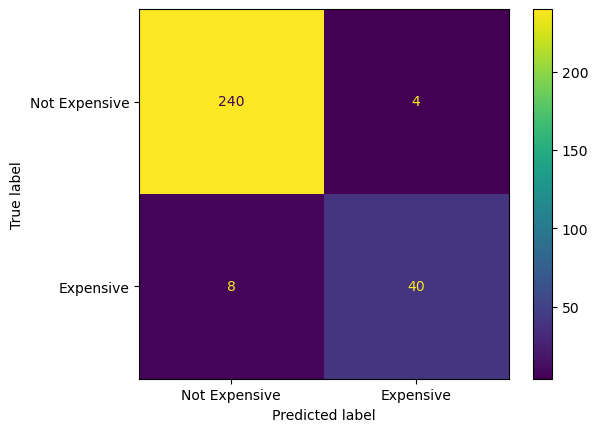

In [496]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Expensive', 'Expensive'])
disp.plot()

plt.show()

### Grid Search

In [497]:
param_grid = {
    "preprocessor__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "model__learning_rate": np.arange(0.01, 1, 0.01).tolist(),
    "model__n_estimators": range(20, 200),
    "model__max_depth": range(1,30),
    "model__min_child_weight": range(1,25)
}

In [498]:
search = RandomizedSearchCV(
    pipeline_adasyn,
    param_grid,
    cv=5,
    n_iter=1000,
    verbose=1,
    n_jobs=-2
)

In [499]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 13, 17, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 17, 18, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.w

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['LotArea',
                                                                                'LotFrontage',
                                                                                'TotalBsmtSF',
                                                                                'BedroomAbvGr',
                                                                                'Fireplaces',
                                                                                'PoolArea',
                                                                                'GarageCars',
                                                                                'WoodDeckSF',
                                                                                'ScreenPorch',
                                                                                'MSSubClass',
                                                                                'OverallQual',
                                                                                'OverallCond',
                                                                                'Year...
                   param_distributions={'model__learning_rate': [0.01, 0.02,
                                                                 0.03, 0.04,
                                                                 0.05, 0.06,
                                                                 0.07, 0.08,
                                                                 0.09, 0.1,
                                                                 0.11, 0.12,
                                                                 0.13, 0.14,
                                                                 0.15, 0.16,
                                                                 0.17, 0.18,
                                                                 0.19, 0.2,
                                                                 0.21, 0.22,
                                                                 0.23, 0.24,
                                                                 0.25, 0.26,
                                                                 0.27, 0.28,
                                                                 0.29, 0.3, ...],
                                        'model__max_depth': range(1, 30),
                                        'model__min_child_weight': range(1, 25),
                                        'model__n_estimators': range(20, 200),
                                        'preprocessor__num_pipe__simpleimputer__strategy': ['mean',
                                                                                            'median']},
                   verbose=1)

In [500]:
search.best_score_

0.9469315138843036

In [501]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

1.0

In [502]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [17, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.958904109589041

In [503]:
search.best_params_

{'preprocessor__num_pipe__simpleimputer__strategy': 'median',
 'model__n_estimators': 150,
 'model__min_child_weight': 1,
 'model__max_depth': 4,
 'model__learning_rate': 0.2}

In [504]:
recall_score(y_test, y_test_pred)

0.8541666666666666

### Classification performance metrics

#### Confusion Matrix

In [505]:
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [17, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [506]:
cm = confusion_matrix(y_test, y_test_pred)

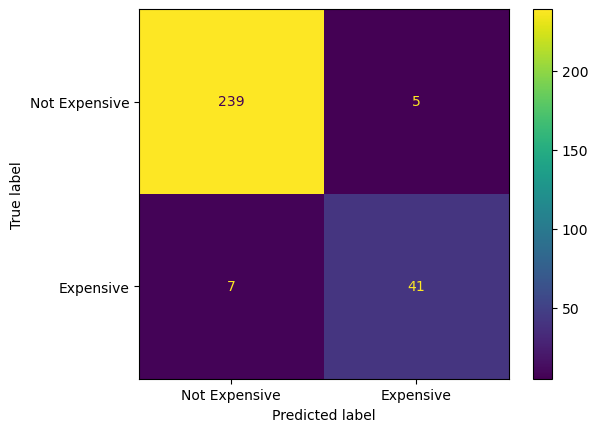

In [507]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Expensive', 'Expensive'])
disp.plot()

plt.show()

#### Cohen’s Kappa Coefficient

In [508]:
kappa_score = cohen_kappa_score(y_test, y_test_pred)
print(kappa_score)

0.8478638416116707


In [509]:
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8723


In [510]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

Specificity: 0.9795


In [511]:
precision = precision_score(y_test, y_test_pred)
precision

0.8913043478260869

In [512]:
recall_score(y_test, y_test_pred)

0.8541666666666666

# Uploading the final result

## Training model on X & y

In [463]:
new_data = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/Final_Data/test.csv')

In [464]:
new_data.columns

Index(['Id', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr',
       'Fireplaces', 'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch',
       'MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu',
       'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal',
       'MoSold', 'YrSold', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtFinT

In [465]:
X_train.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'TotRmsAbvGrd',
       'GarageYrBlt', 'GarageArea', 'OpenPorchSF', 'MoSold', 'YrSold',
       'Fence'],
      dtype='object')

In [466]:
id_col = new_data.pop('Id')
new_data = new_data.loc[:, X_train.columns]
new_data.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'TotRmsAbvGrd',
       'GarageYrBlt', 'GarageArea', 'OpenPorchSF', 'MoSold', 'YrSold',
       'Fence'],
      dtype='object')

In [467]:
search.best_estimator_.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'GarageCars', 'WoodDeckSF',
                                                   'ScreenPorch', 'MSSubClass',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'Bsm...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.47000000000000003, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=16,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, n_estimators=176,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [468]:
expensive = search.best_estimator_.predict(new_data)
expensive

array([0, 0, 0, ..., 0, 0, 0])

In [469]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'Expensive':expensive
})

In [470]:
submission_file.head()

,Id,Expensive
0,1461,0
1,1462,0
2,1463,0
3,1464,0
4,1465,0


In [471]:
submission_file.to_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/Final_Data/submission_merle_2.csv',index=False)